# Create a polynomial chaos metamodel by integration on the cantilever beam

In this example, we create a polynomial chaos metamodel by integration on the cantilever beam example. 

In order to do this, we use the `GaussProductExperiment` class. 

In [1]:
import openturns as ot

In [2]:
dist_E = ot.Beta(0.9, 2.27, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3) # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250., 260.) # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310., 450.) # in cm^4
dist_I.setDescription(["I"])

myDistribution = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [3]:
dim_input = 4 # dimension of the input
dim_output = 1 # dimension of the output

def function_beam(X):
    E, F, L, I = X
    Y = F* (L**3) /  (3 * E * I)
    return [Y]

g = ot.PythonFunction( dim_input, dim_output, function_beam)
g.setInputDescription(myDistribution.getDescription())

## Create a polynomial chaos decomposition

We create the multivariate polynomial basis by tensorization of the univariate polynomials and the default linear enumerate rule. 

In [4]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory([dist_E, dist_F, dist_L, dist_I])

Generate an training sample of size N with MC simulation.

In [5]:
N = 50 # size of the experimental design
inputTrain = myDistribution.getSample(N)
outputTrain = g(inputTrain)

We select the `FixedStrategy` truncation rule, which corresponds to using the first `P` polynomials of the polynomial basis. In this case, we select `P` using the `getStrataCumulatedCardinal` method, so that all polynomials with total degree lower or equal to 5 are used. 

In [6]:
totalDegree = 5
enumfunc = multivariateBasis.getEnumerateFunction()
P = enumfunc.getStrataCumulatedCardinal(totalDegree)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
adaptiveStrategy

class=FixedStrategy derived from class=AdaptiveStrategyImplementation maximumDimension=126

We see that the number of polynomials is equal to 126. This will lead to the computation of 126 coefficients. 

We now set the method used to compute the coefficients; we select the integration method. 

We begin by getting the standard measure associated with the multivariate polynomial basis. We see that the range of the `Beta` distribution has been standardized into the [-1,1] interval. This is the same for the `Uniform` distribution and the second `Beta` distribution.

In [7]:
distributionMu = multivariateBasis.getMeasure()
distributionMu

class=ComposedDistribution name=ComposedDistribution dimension=4 copula=class=IndependentCopula name=IndependentCopula dimension=4 marginal[0]=class=Beta name=Beta dimension=1 alpha=0.9 beta=2.27 a=-1 b=1 marginal[1]=class=LogNormal name=LogNormal dimension=1 muLog=9.46206 sigmaLog=0.554513 gamma=0 marginal[2]=class=Uniform name=Uniform dimension=1 a=-1 b=1 marginal[3]=class=Beta name=Beta dimension=1 alpha=2.5 beta=1.5 a=-1 b=1

In [8]:
marginalDegrees = [4] * dim_input
experiment = ot.GaussProductExperiment(distributionMu, marginalDegrees)

We can see the size of the associated design of experiments.

In [9]:
experiment.generate().getSize()

256

The choice of the `GaussProductExperiment` rule leads to 256 evaluations of the model. 

In [10]:
projectionStrategy = ot.IntegrationStrategy(experiment)

We can now create the functional chaos. 

In [11]:
chaosalgo = ot.FunctionalChaosAlgorithm(g, myDistribution, adaptiveStrategy, projectionStrategy)
chaosalgo.run()

Get the result


In [12]:
result = chaosalgo.getResult()

The `getMetaModel` method returns the metamodel function. 

In [13]:
metamodel = result.getMetaModel()

## Validate the metamodel

Generate a validation sample (which is independent of the training sample).

In [14]:
n_valid = 1000
inputTest = myDistribution.getSample(n_valid)
outputTest = g(inputTest)

The `MetaModelValidation` class validates the metamodel based on a validation sample. 

In [15]:
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)

Compute the $Q^2$ predictivity coefficient

In [16]:
Q2 = val.computePredictivityFactor()
Q2

0.9999582091949566

Plot the observed versus the predicted outputs.

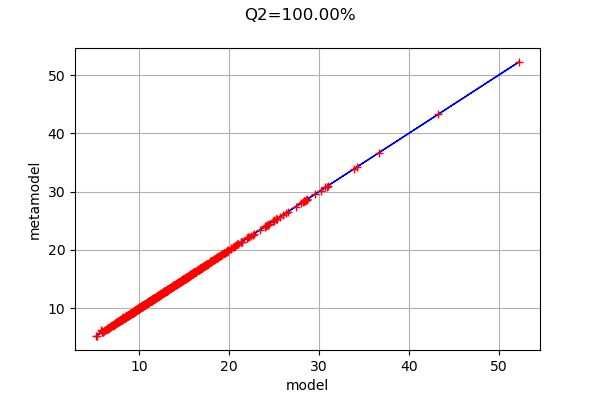

In [17]:
graph = val.drawValidation()
graph.setTitle("Q2=%.2f%%" % (Q2*100))
graph.setLegends([""])
graph

## Sensitivity analysis

Retrieve Sobol' sensitivity measures associated to the polynomial chaos decomposition of the model.

In [18]:
chaosSI = ot.FunctionalChaosSobolIndices(result) 
print( chaosSI.summary() )

 input dimension: 4
 output dimension: 1
 basis size: 126
 mean: [12.6676]
 std-dev: [4.28807]
------------------------------------------------------------
Index   | Multi-indice                  | Part of variance  
------------------------------------------------------------
      2 | [0,1,0,0]                     | 0.78543
      1 | [1,0,0,0]                     | 0.128439
      4 | [0,0,0,1]                     | 0.0546688
      6 | [1,1,0,0]                     | 0.0115595
      3 | [0,0,1,0]                     | 0.0100596
------------------------------------------------------------


------------------------------------------------------------
Component | Sobol index            | Sobol total index      
------------------------------------------------------------
        0 | 0.130668               | 0.143489              
        1 | 0.78543                | 0.803144              
        2 | 0.0100606              | 0.0112004             
        3 | 0.0550877              | 0.

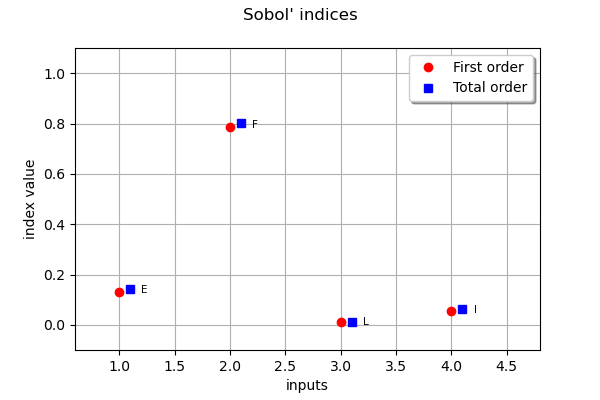

In [19]:
first_order = [chaosSI.getSobolIndex(i) for i in range(dim_input)]
total_order = [chaosSI.getSobolTotalIndex(i) for i in range(dim_input)]
input_names = g.getInputDescription()
ot.SobolIndicesAlgorithm.DrawSobolIndices(input_names, first_order, total_order)

## Conclusion

We see that the coefficients are particularily well computed since the Q2 coefficient is excellent (perfect ?), even with a relatively limited amount of simulation (256 points). 